# Only Analysis the Location and Extreme Type

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": [
        "Times New Roman",   # 如果存在，优先
        "Liberation Serif",  # Ubuntu / Debian 常见
        "Nimbus Roman",      # TeX / Ghostscript 常见
        "DejaVu Serif"       # Matplotlib 默认兜底
    ],
    "mathtext.fontset": "stix",       # 数学符号更像 Times
    "axes.unicode_minus": False,
})

In [2]:
ori = np.load('../Data-Driven Analysis/Result/DDPM + student-t Example 5(2)/origin_data_unnorm_toyexample.npy')
gen = np.load('../Data-Driven Analysis/Result/DDPM + student-t Example 5(2)/generate_data_unnorm_toyexample.npy')

In [5]:
def visualization_distribution(ori_data, generated_data):
    """PCA / tSNE / KDE visualization in a 3x3 grid:
       Col1: Original, Col2: Synthetic, Col3: Overlay (Original + Synthetic)
    """

    ori_data = np.asarray(ori_data)
    generated_data = np.asarray(generated_data)

    no, seq_len, dim = ori_data.shape

    # (no, seq_len): each sample -> mean over feature dim
    # 原来你的写法是循环拼接，这里等价向量化（更快、更简洁）
    prep_data = np.mean(ori_data, axis=2)        # (no, seq_len)
    prep_data_hat = np.mean(generated_data, axis=2)

    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    titles = ["Original", "Synthetic", "Overlay"]

    # ===================== Row 1: PCA =====================
    pca = PCA(n_components=2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)

    # Original
    axes[0, 0].scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.2, s=10)
    axes[0, 0].set_title(f"PCA | {titles[0]}")
    axes[0, 0].set_xlabel("x-pca")
    axes[0, 0].set_ylabel("y-pca")

    # Synthetic
    axes[0, 1].scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], alpha=0.2, s=10)
    axes[0, 1].set_title(f"PCA | {titles[1]}")
    axes[0, 1].set_xlabel("x-pca")
    axes[0, 1].set_ylabel("y-pca")

    # Overlay
    axes[0, 2].scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.2, s=10, label="Original")
    axes[0, 2].scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], alpha=0.2, s=10, label="Synthetic")
    axes[0, 2].set_title(f"PCA | {titles[2]}")
    axes[0, 2].set_xlabel("x-pca")
    axes[0, 2].set_ylabel("y-pca")
    axes[0, 2].legend(frameon=False)

    # ===================== Row 2: t-SNE =====================
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)

    # sklearn 有的版本是 n_iter，有的版本是 max_iter；你原来用 n_iter，这里保持不动
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(prep_data_final)

    tsne_ori = tsne_results[:no]
    tsne_hat = tsne_results[no:]

    # Original
    axes[1, 0].scatter(tsne_ori[:, 0], tsne_ori[:, 1], alpha=0.2, s=10)
    axes[1, 0].set_title(f"t-SNE | {titles[0]}")
    axes[1, 0].set_xlabel("x-tsne")
    axes[1, 0].set_ylabel("y-tsne")

    # Synthetic
    axes[1, 1].scatter(tsne_hat[:, 0], tsne_hat[:, 1], alpha=0.2, s=10)
    axes[1, 1].set_title(f"t-SNE | {titles[1]}")
    axes[1, 1].set_xlabel("x-tsne")
    axes[1, 1].set_ylabel("y-tsne")

    # Overlay
    axes[1, 2].scatter(tsne_ori[:, 0], tsne_ori[:, 1], alpha=0.2, s=10, label="Original")
    axes[1, 2].scatter(tsne_hat[:, 0], tsne_hat[:, 1], alpha=0.2, s=10, label="Synthetic")
    axes[1, 2].set_title(f"t-SNE | {titles[2]}")
    axes[1, 2].set_xlabel("x-tsne")
    axes[1, 2].set_ylabel("y-tsne")
    axes[1, 2].legend(frameon=False)

    # ===================== Row 3: KDE =====================
    flat_ori = prep_data.reshape(-1)
    flat_hat = prep_data_hat.reshape(-1)

    # Original
    sns.kdeplot(flat_ori, linewidth=3, ax=axes[2, 0])
    axes[2, 0].set_title(f"KDE | {titles[0]}")
    axes[2, 0].set_xlabel("Data Value")
    axes[2, 0].set_ylabel("Density")

    # Synthetic
    sns.kdeplot(flat_hat, linewidth=3, linestyle="--", ax=axes[2, 1])
    axes[2, 1].set_title(f"KDE | {titles[1]}")
    axes[2, 1].set_xlabel("Data Value")
    axes[2, 1].set_ylabel("Density")

    # Overlay
    sns.kdeplot(flat_ori, linewidth=3, ax=axes[2, 2], label="Original")
    sns.kdeplot(flat_hat, linewidth=3, linestyle="--", ax=axes[2, 2], label="Synthetic")
    axes[2, 2].set_title(f"KDE | {titles[2]}")
    axes[2, 2].set_xlabel("Data Value")
    axes[2, 2].set_ylabel("Density")
    axes[2, 2].legend(frameon=False)

    plt.tight_layout()
    plt.show()
    plt.close()


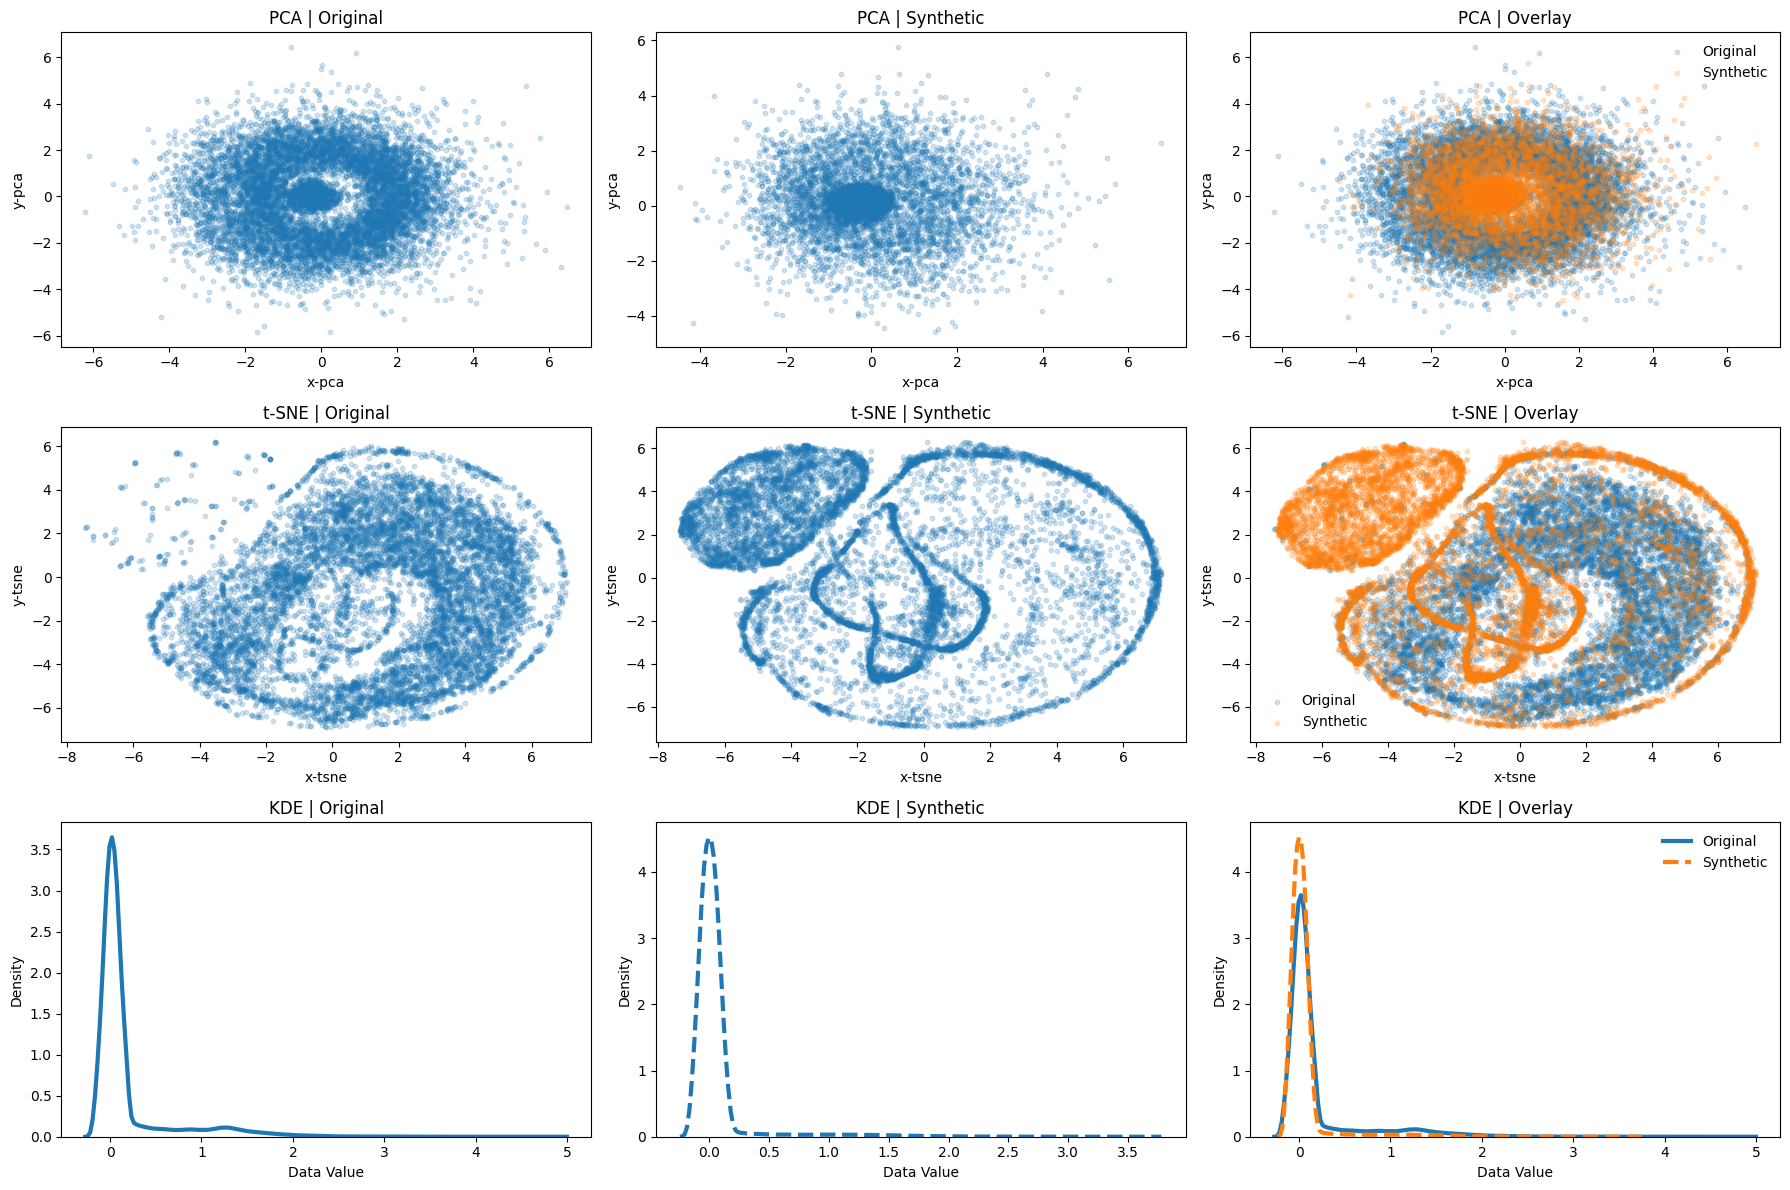

In [6]:
visualization_distribution(ori, gen)

In [7]:
def _local_maxima_above_thr(x1d: np.ndarray, thr: float) -> np.ndarray:
    x = x1d.astype(np.float32)
    L = x.size
    if L < 3:
        return np.array([], dtype=np.int32)
    mid = x[1:-1]
    left = x[:-2]
    right = x[2:]
    mask = (mid > float(thr)) & (mid > left) & (mid >= right)
    idx = np.flatnonzero(mask) + 1
    return idx.astype(np.int32)

def _nms_peaks(peaks: np.ndarray, x: np.ndarray, min_gap: int) -> np.ndarray:
    if peaks.size == 0:
        return peaks
    order = np.argsort(-x[peaks])  # desc by height
    chosen = []
    for j in order:
        t0 = int(peaks[j])
        if all(abs(t0 - int(tt)) >= int(min_gap) for tt in chosen):
            chosen.append(t0)
    chosen.sort()
    return np.asarray(chosen, dtype=np.int32)

def _extract_run_bounds(x: np.ndarray, t0: int, thr: float) -> tuple[int, int]:
    L = x.size
    l = t0
    while l - 1 >= 0 and x[l - 1] > float(thr):
        l -= 1
    r = t0
    while r + 1 < L and x[r + 1] > float(thr):
        r += 1
    return int(l), int(r)

def _roughness_score(seg: np.ndarray) -> float:
    seg = seg.astype(np.float32)
    if seg.size < 5:
        return 0.0
    peak = float(np.max(seg) + 1e-12)
    y = (seg / peak).astype(np.float32)
    d2 = y[2:] - 2.0*y[1:-1] + y[:-2]
    return float(np.mean(np.abs(d2)))

def _classify_shape_jitter(
    x: np.ndarray,
    l: int,
    r: int,
    jitter_thr: float = 0.06,
    skew_log_thr: float = 0.55,
) -> int:
    seg = x[l:r+1]
    if seg.size == 0:
        return 0

    # 1) skew first
    j = int(np.argmax(seg))
    t_peak = l + j
    left_len = max(0, t_peak - l)
    right_len = max(0, r - t_peak)
    skew_ratio = (right_len + 1.0) / (left_len + 1.0)
    skew_score = abs(float(np.log(skew_ratio)))
    if skew_score >= float(skew_log_thr):
        return 2

    # 2) jitter second
    rs = _roughness_score(seg.astype(np.float32))
    if rs >= float(jitter_thr):
        return 1

    return 0

def extract_events_stats(
    X: np.ndarray,
    thr: float = 1.0,
    min_gap: int = 15,
    class_width_thr: int = 11,
    class_skew_log_thr: float = 0.6
):
    """
    Output events[i] list of dicts:
      {
        "t0": int,           seed peak index
        "amp_raw": float,    raw peak at seed t0
        "shape": int,        0/1/2 using new classifier
        "l","r": int         threshold run bounds
      }
    """
    X = np.asarray(X, dtype=np.float32)
    x = X[:, :, 0] if X.ndim == 3 else X
    N, L = x.shape

    out = []
    for i in range(N):
        xi = x[i]
        peaks = _local_maxima_above_thr(xi, thr=thr)
        peaks = _nms_peaks(peaks, xi, min_gap=int(min_gap))

        ev_i = []
        for t0 in peaks:
            t0 = int(t0)
            l, r = _extract_run_bounds(xi, t0, thr=thr)
            shape = _classify_shape_jitter(
                xi, l, r,
                jitter_thr=0.155,
                skew_log_thr=0.45,
            )
            ev_i.append({
                "t0": t0,
                "amp_raw": float(xi[t0]),
                "shape": int(shape),
                "l": int(l),
                "r": int(r),
            })
        out.append(ev_i)

    return out

def summarize_events(events, n_shapes: int = 3):
    K_per_sample = np.array([len(ei) for ei in events], dtype=np.int32)
    t0s, amps, shapes = [], [], []
    for ei in events:
        for e in ei:
            t0s.append(int(e["t0"]))
            amps.append(float(e["amp_raw"]))
            shapes.append(int(e["shape"]))
    if len(t0s) == 0:
        return K_per_sample, np.array([], np.int32), np.array([], np.float32), np.zeros(n_shapes, np.int64)
    t0s = np.asarray(t0s, dtype=np.int32)
    amps = np.asarray(amps, dtype=np.float32)
    shapes = np.asarray(shapes, dtype=np.int32)
    shape_counts = np.bincount(shapes, minlength=n_shapes).astype(np.int64)
    return K_per_sample, t0s, amps, shape_counts

In [8]:
def plot_random_5(X, seed=0):
    X = np.asarray(X)
    X2 = X[:, :, 0] if X.ndim == 3 else X  # (N,L)
    N, L = X2.shape

    rng = np.random.default_rng(seed)
    idx = rng.choice(N, size=min(5, N), replace=False)

    t = np.arange(L)
    plt.figure(figsize=(10, 4))
    for i in idx:
        plt.plot(t, X2[i], alpha=0.9, label=f"idx={int(i)}")
    plt.title("Random 5 samples from X")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

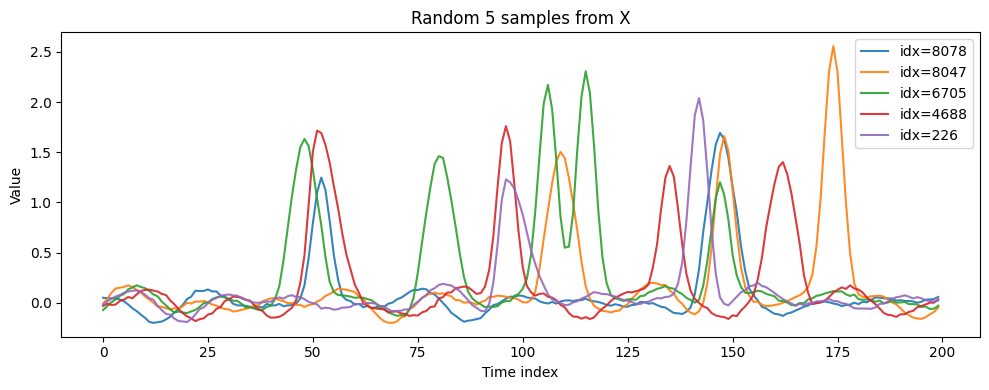

In [9]:
plot_random_5(ori,seed=5)

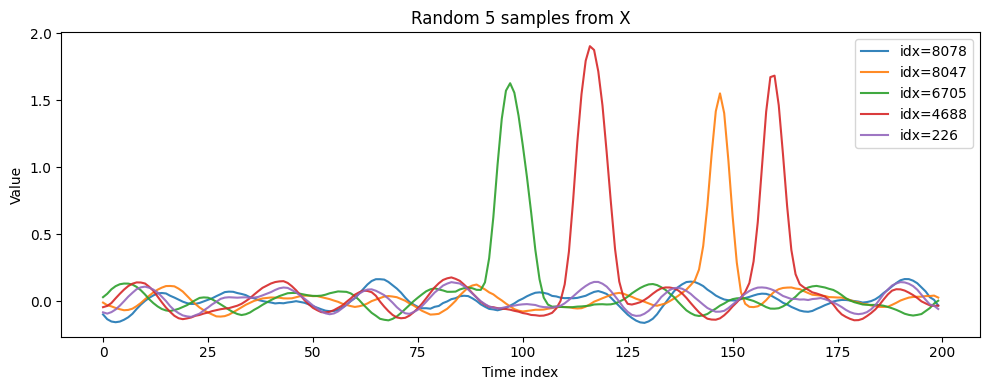

In [10]:
plot_random_5(gen,seed=5)

In [11]:
orievent = extract_events_stats(ori, thr=1.0, min_gap=15)
genevent = extract_events_stats(gen, thr=1.0, min_gap=15)

shapename = {0: 'smooth_gaussian', 1: 'jittered_peak', 2: 'skewed_gaussian'}

In [78]:
def plot_event_location_ratio(
    X_ori, events_ori,
    X_gen, events_gen,
    L=None,
    title="Location distribution of events (t_peak)",
    centers=(50, 100, 150),
    step=1,                 # 下采样显示用
    smooth=0,               # 0 不平滑；>0 moving average
    xlim=None,
    ylim=None,
    savepath=None, dpi=300,
):
    """
    只可视化 location (t_peak) 的分布，对比 ORI vs GEN。
    y轴：比例（每个t_peak占全部events的比例）。
    风格：字号、legend、配色等对齐 plot_event_peak_amplitude_hist 的标准。
    """

    def _extract_t_peaks(X, events, L):
        X = np.asarray(X, dtype=np.float32)
        x = X[:, :, 0] if X.ndim == 3 else X
        N, Lx = x.shape

        if L is None:
            L = Lx
        else:
            L = int(L)

        t_peaks = []
        for i, ei in enumerate(events):
            xi = x[i]
            for e in ei:
                l = int(e["l"])
                r = int(e["r"])
                l = max(0, min(l, Lx - 1))
                r = max(0, min(r, Lx - 1))
                if r < l:
                    l, r = r, l

                seg = xi[l:r+1]
                if seg.size == 0:
                    continue
                j = int(np.argmax(seg))
                t_peaks.append(l + j)

        return np.asarray(t_peaks, dtype=np.int32), L

    def _counts_to_ratio(t_peaks, L):
        if t_peaks.size == 0:
            return np.zeros(L, dtype=np.float32)
        c = np.bincount(t_peaks, minlength=L).astype(np.float32)
        s = float(c.sum())
        return c / s if s > 0 else np.zeros(L, dtype=np.float32)

    def _maybe_smooth(y, win):
        if win is None or int(win) <= 1:
            return y
        win = int(win)
        k = np.ones(win, dtype=np.float32) / float(win)
        return np.convolve(y, k, mode="same")

    # -------- extract & ratio --------
    t_ori, L1 = _extract_t_peaks(X_ori, events_ori, L)
    t_gen, L2 = _extract_t_peaks(X_gen, events_gen, L1)
    L = L2

    p_ori = _maybe_smooth(_counts_to_ratio(t_ori, L), smooth)
    p_gen = _maybe_smooth(_counts_to_ratio(t_gen, L), smooth)

    step = max(1, int(step))
    xs = np.arange(0, L, step)
    y_ori = p_ori[xs]
    y_gen = p_gen[xs]

    # -------- plot (style aligned) --------
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(xs, y_ori, linewidth=2.6, label=f"Origin Data", color="tab:blue")
    ax.plot(xs, y_gen, linewidth=2.6, label=f"Diff (Value)", color="tab:green")

    # center lines
    for c in centers:
        ax.vlines(
            x=float(c),
            ymin=0,
            ymax=0.02,
            colors="black",
            linestyles="--",
            linewidth=2.0,
            zorder=0,
        )

    # ax.set_title(title)  # 你标准里 title 是注释掉的，这里也默认不显示
    ax.set_xlabel("Time index", fontsize=40)
    ax.set_ylabel("Percentage", fontsize=40)
    ax.tick_params(axis="x", labelsize=40)
    ax.tick_params(axis="y", labelsize=40)

    if xlim is not None:
        ax.set_xlim(float(xlim[0]), float(xlim[1]))
    if ylim is not None:
        ax.set_ylim(0,0.03)

    ax.legend(loc="upper right", bbox_to_anchor=(1.05, 1.08), fontsize=35)
    ax.set_xticks([0,50,100,150,200])
    ax.set_yticks([0,0.01,0.02,0.03],['0%','1%','2%','3%'])
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()
   # return fig, ax, {"p_ori": p_ori, "p_gen": p_gen, "t_ori": t_ori, "t_gen": t_gen, "L": L}

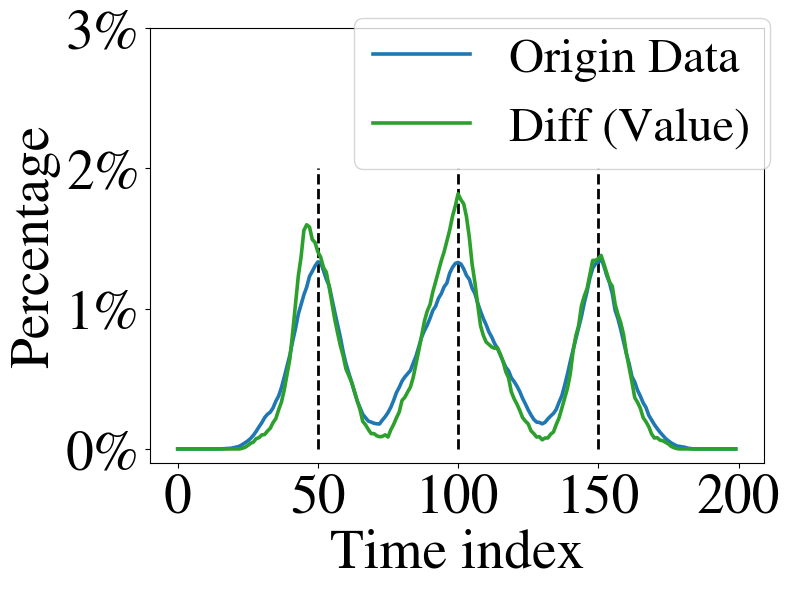

In [79]:
savepath = "../Data-Driven Analysis/Plot/extreme location"
plot_event_location_ratio(
    ori, orievent,
    gen, genevent,
    L=200,
    savepath=savepath,
    smooth = 5,
    dpi=300,
)

In [80]:
def plot_event_shape_distribution_bar(
    shapes_ori, shapes_gen,
    shape_names=None,          # dict: {id: "name"} 可选
    title="Shape distribution (events)",
    normalize=True,            # True: y轴为比例；False: y轴为count
    savepath=None, dpi=300,
):
    """
    shapes_ori / shapes_gen: 1D array-like of shape labels for events (int)
    画 ORI vs GEN 的 shape 分布柱状图（side-by-side bars）
    """

    if shape_names is None:
        shape_names = {}  # fallback: shape0, shape1, ...

    shapes_ori = np.asarray(shapes_ori, dtype=np.int32).ravel()
    shapes_gen = np.asarray(shapes_gen, dtype=np.int32).ravel()

    max_id = -1
    if shapes_ori.size > 0:
        max_id = max(max_id, int(shapes_ori.max()))
    if shapes_gen.size > 0:
        max_id = max(max_id, int(shapes_gen.max()))
    n_shapes = max(1, max_id + 1)

    c_ori = np.bincount(shapes_ori, minlength=n_shapes).astype(np.float32) if shapes_ori.size > 0 else np.zeros(n_shapes, dtype=np.float32)
    c_gen = np.bincount(shapes_gen, minlength=n_shapes).astype(np.float32) if shapes_gen.size > 0 else np.zeros(n_shapes, dtype=np.float32)

    if normalize:
        s1 = float(c_ori.sum())
        s2 = float(c_gen.sum())
        y_ori = c_ori / s1 if s1 > 0 else c_ori
        y_gen = c_gen / s2 if s2 > 0 else c_gen
        ylabel = "Percentage"
    else:
        y_ori, y_gen = c_ori, c_gen
        ylabel = "Count"

    xs = np.arange(n_shapes, dtype=np.float32)
    labels = ['Smooth-G', 'Jitter-P', 'Skew-G']

    fig, ax = plt.subplots(figsize=(8, 6))

    w = 0.36
    ax.bar(xs - w/2, y_ori, width=w, label=f"Origin Data", color="tab:blue", alpha=0.85)
    ax.bar(xs + w/2, y_gen, width=w, label=f"Diff (Value)", color="tab:green", alpha=0.85)

    # ax.set_title(title)  # 你标准图里 title 默认不显示，这里也注释掉
    ax.set_xlabel("Shape type", fontsize=40)
    ax.set_ylabel(ylabel, fontsize=40)
    ax.set_xticks(xs)
    ax.set_xticklabels(labels, rotation=15)
    ax.set_ylim(0,1)
    ax.set_yticks([0,0.25,0.5,0.75,1],['0%','25%','50%','75%','100%'])
    ax.tick_params(axis="x", labelsize=35)
    ax.tick_params(axis="y", labelsize=35)

    ax.legend(loc="upper right", bbox_to_anchor=(1.10, 1.08), fontsize=35)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    plt.show()

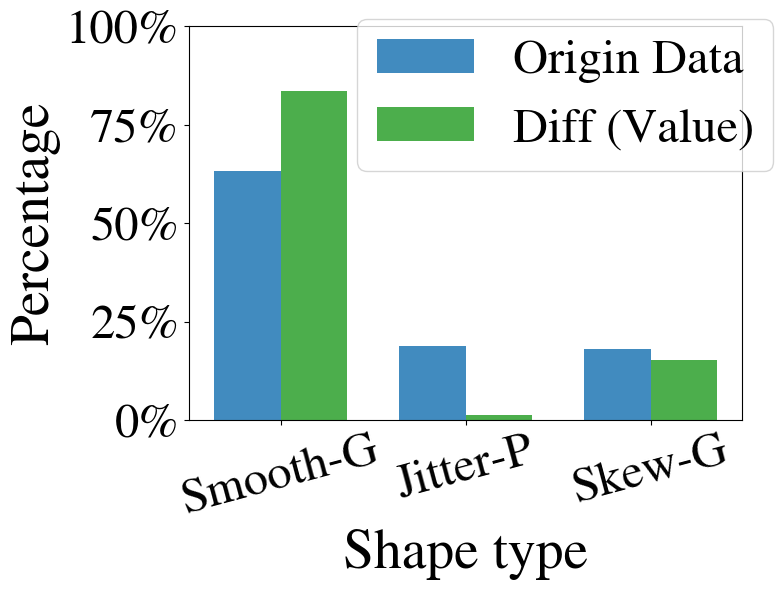

In [81]:
shapes_ori = np.array([e["shape"] for ei in orievent for e in ei], dtype=int)
shapes_gen = np.array([e["shape"] for ei in genevent for e in ei], dtype=int)

savepath = "../Data-Driven Analysis/Plot/extreme shape"
plot_event_shape_distribution_bar(shapes_ori, shapes_gen, normalize=True,savepath=savepath)